In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuration parameters
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2  # Validation set will be taken from training data
TARGET_COLUMN = 'precipitation'
SEQUENCE_LENGTH = 7  # To make prediction based on past week for LSTM

# Training parameters
PRETRAINED_MODEL = None  # Load a pretrained model (If available)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
EARLY_STOP = 25  # If validation does not improve for 25 epochs, stop training
EPOCHS = 300
HIDDEN_DIM = 128
LAYER_DIM = 2
DROPOUT = 0.3  # Randomly turns off 30% of neurons during training to prevent overfitting
UNDERESTIMATION_WEIGHT = 1.5  # Penalty for underestimating precipitation

# Added parameters for the producer-consumer pattern
CAPACITY = 15  # Limits memory by capping the buffer size
DATALOADER_LOAD_THRESHOLD = 1  # Datapoints loaded per operation
TRAINER_READ_THRESHOLD = 3  # Datapoints consumed by trainer per operation
INFERENCE_READ_THRESHOLD = 1  # Datapoints consumed by inference per operation

# Simulated processing times (Seconds)
DATALOADER_WAIT_TIME = 1  # Data Loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4  # Training is compute Intensive (Slowest)
INFERENCE_WAIT_TIME = 1  # Inference (Moderate)

# Set device for model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the London weather dataset
file_path = '/content/London_Weather.csv'

In [2]:
# Define LSTM model with attention mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, num_layers=LAYER_DIM, output_dim=1, dropout=DROPOUT):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layer
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        # LSTM forward
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # shape: (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)  # shape: (batch_size, seq_len, 1)

        # Apply attention to LSTM output
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # shape: (batch_size, hidden_dim)

        # Final prediction
        output = self.fc(context_vector)  # shape: (batch_size, output_dim)

        return output

# Custom loss function that penalizes underestimation of precipitation more than overestimation
class AsymmetricMSELoss(nn.Module):
    def __init__(self, underestimation_weight=UNDERESTIMATION_WEIGHT):
        super(AsymmetricMSELoss, self).__init__()
        self.underestimation_weight = underestimation_weight

    def forward(self, predictions, targets):
        # Calculate residuals
        residuals = targets - predictions

        # Apply higher penalty to underestimation
        weighted_residuals = torch.where(
            residuals > 0,
            residuals * self.underestimation_weight,
            residuals
        )

        # Compute MSE with weighted residuals
        loss = torch.mean(weighted_residuals ** 2)
        return loss

In [3]:
class Preprocessing:
    def __init__(self, file_path=None):
        self.file_path = file_path
        self.data = None
        self.clean_data = None
        self.train_size = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.scaler = None
        self.X_train_seq = None
        self.y_train_seq = None
        self.X_test_seq = None
        self.y_test_seq = None

    def load_data(self, file_path=None):
        file_path = file_path if file_path is not None else self.file_path
        self.data = pd.read_csv(file_path)
        return self.data

    def clean_and_prepare_data(self):
        # Convert date string to datetime object
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Add engineered temporal features
        self.data['day_of_year'] = self.data['date'].dt.dayofyear
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day
        self.data['season'] = (self.data['month'] % 12 + 3) // 3  # 1: spring, 2: summer, 3: fall, 4: winter
        self.data['is_weekend'] = self.data['date'].dt.dayofweek >= 5

        # One-hot encode season
        season_dummies = pd.get_dummies(self.data['season'], prefix='season')
        self.data = pd.concat([self.data, season_dummies], axis=1)

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Remove rows with missing values
        self.clean_data = self.data.dropna()

        return self.clean_data

    def add_features(self):
        # Add lags for key variables based on correlation
        for lag in range(1, 4):  # Use 3 lags
            self.clean_data[f'precip_lag_{lag}'] = self.clean_data[TARGET_COLUMN].shift(lag)
            self.clean_data[f'pressure_lag_{lag}'] = self.clean_data['pressure'].shift(lag)
            self.clean_data[f'cloud_cover_lag_{lag}'] = self.clean_data['cloud_cover'].shift(lag)

        # Add moving averages
        self.clean_data['precip_ma_3'] = self.clean_data[TARGET_COLUMN].rolling(window=3).mean()
        self.clean_data['precip_ma_7'] = self.clean_data[TARGET_COLUMN].rolling(window=7).mean()
        self.clean_data['pressure_ma_3'] = self.clean_data['pressure'].rolling(window=3).mean()
        self.clean_data['cloud_cover_ma_3'] = self.clean_data['cloud_cover'].rolling(window=3).mean()

        # Remove rows with NaN due to lagging/moving averages
        self.clean_data = self.clean_data.dropna()

        return self.clean_data

    def create_sequences(self, data, seq_length):
        xs = []
        ys = []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            # IMPORTANT: This was the critical difference - original uses index 0, not -1
            y = data[i + seq_length, 0]  # Target precipitation
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    def prepare_data_for_model(self):
        # Select features based on correlation analysis and domain knowledge
        selected_columns = [
            'pressure', 'cloud_cover', 'sunshine',
            'precip_lag_1', 'precip_lag_2', 'precip_lag_3',
            'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3',
            'cloud_cover_lag_1', 'cloud_cover_lag_2', 'cloud_cover_lag_3',
            'precip_ma_3', 'precip_ma_7', 'pressure_ma_3', 'cloud_cover_ma_3',
            'day_of_year', 'month', 'season_1', 'season_2', 'season_3', 'season_4'
        ]

        # Prepare input data and target
        X = self.clean_data[selected_columns]
        y = self.clean_data[TARGET_COLUMN].values

        # Calculate train size
        self.train_size = int(len(X) * TRAIN_RATIO)

        # Split data chronologically
        self.X_train, self.X_test = X[:self.train_size], X[self.train_size:]
        self.y_train, self.y_test = y[:self.train_size], y[self.train_size:]

        # Scale features using robust scaler (less sensitive to outliers)
        self.scaler = RobustScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Combine features and target for sequence creation - EXACTLY as in original code
        train_data = np.column_stack([self.X_train_scaled, self.y_train])
        test_data = np.column_stack([self.X_test_scaled, self.y_test])

        # Create sequences for LSTM
        self.X_train_seq, self.y_train_seq = self.create_sequences(train_data, SEQUENCE_LENGTH)
        self.X_test_seq, self.y_test_seq = self.create_sequences(test_data, SEQUENCE_LENGTH)

        # Convert to PyTorch tensors
        self.X_train_seq_tensor = torch.FloatTensor(self.X_train_seq)
        self.y_train_seq_tensor = torch.FloatTensor(self.y_train_seq).unsqueeze(1)
        self.X_test_seq_tensor = torch.FloatTensor(self.X_test_seq)
        self.y_test_seq_tensor = torch.FloatTensor(self.y_test_seq).unsqueeze(1)

        # Move data to device
        self.X_train_seq_tensor = self.X_train_seq_tensor.to(device)
        self.y_train_seq_tensor = self.y_train_seq_tensor.to(device)
        self.X_test_seq_tensor = self.X_test_seq_tensor.to(device)
        self.y_test_seq_tensor = self.y_test_seq_tensor.to(device)

        return self.X_train_seq_tensor, self.y_train_seq_tensor, self.X_test_seq_tensor, self.y_test_seq_tensor

    def process(self, file_path=None):
        self.load_data(file_path)
        self.clean_and_prepare_data()
        self.add_features()
        return self.prepare_data_for_model()

In [4]:
class Training:
    def __init__(self):
        self.model = None
        self.train_losses = []
        self.val_losses = []

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=EPOCHS, patience=EARLY_STOP):
        self.model = model

        criterion = AsymmetricMSELoss(underestimation_weight=UNDERESTIMATION_WEIGHT)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()

            # Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = criterion(val_outputs, y_val)

                # Use standard MSE for monitoring
                val_mse = nn.MSELoss()(val_outputs, y_val)

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

            # Update learning rate based on validation loss
            scheduler.step(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val MSE: {val_mse.item():.4f}')

        # Load best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        self.train_losses = train_losses
        self.val_losses = val_losses
        return self.model, train_losses, val_losses

In [5]:
class Inference:
    def __init__(self):
        self.model = None
        self.predictions = None

    def set_model(self, model):
        self.model = model

    def predict_all(self, X_test):
        # Set model to evaluation mode
        self.model.eval()

        # Generate predictions
        with torch.no_grad():
            predictions = self.model(X_test).cpu().numpy().flatten()

        self.predictions = predictions
        return predictions

In [6]:
class Analysis:
    def __init__(self):
        self.true_values = None
        self.predictions = None
        self.metrics = {}
        self.errors = None

    def calculate_metrics(self, true_values, predictions):
        self.true_values = true_values
        self.predictions = predictions

        # Calculate metrics
        self.metrics['MSE'] = mean_squared_error(true_values, predictions)
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])
        self.metrics['MAE'] = mean_absolute_error(true_values, predictions)
        self.metrics['R2'] = r2_score(true_values, predictions)

        print(f"\nLSTM Model Evaluation Metrics:")
        print(f"Mean Squared Error (MSE): {self.metrics['MSE']:.4f}")
        print(f"Root Mean Squared Error (RMSE): {self.metrics['RMSE']:.4f}")
        print(f"Mean Absolute Error (MAE): {self.metrics['MAE']:.4f}")
        print(f"R² Score: {self.metrics['R2']:.4f}")

        return self.metrics

    def analyze_error_distribution(self):
        # Calculate error statistics for days with and without precipitation
        zero_precip_mask = self.true_values == 0
        non_zero_precip_mask = self.true_values > 0

        zero_precip_mae = mean_absolute_error(
            self.true_values[zero_precip_mask],
            self.predictions[zero_precip_mask]
        )

        non_zero_precip_mae = mean_absolute_error(
            self.true_values[non_zero_precip_mask],
            self.predictions[non_zero_precip_mask]
        )

        print(f"\nMAE on days without precipitation: {zero_precip_mae:.4f}")
        print(f"MAE on days with precipitation: {non_zero_precip_mae:.4f}")
        print(f"Percentage of days with precipitation: {np.mean(non_zero_precip_mask)*100:.1f}%")

        # Calculate errors
        self.errors = self.true_values - self.predictions

        return self.errors

    def run_analysis(self, true_values, predictions):
        self.calculate_metrics(true_values, predictions)
        self.analyze_error_distribution()

        return self.metrics, self.errors

In [7]:
class Display:
    def __init__(self, show_loss_plot=True, show_main_plot=True,
                 show_yearly_plot=True, show_error_hist=True, show_scatter_plot=True):
        self.show_loss_plot = show_loss_plot
        self.show_main_plot = show_main_plot
        self.show_yearly_plot = show_yearly_plot
        self.show_error_hist = show_error_hist
        self.show_scatter_plot = show_scatter_plot

    def create_results_dataframe(self, data, train_size, predictions, y_test):
        # Adjust dates to account for sequence length
        test_dates = data.iloc[train_size + SEQUENCE_LENGTH:]['date'].reset_index(drop=True)
        if len(test_dates) > len(predictions):
            test_dates = test_dates[:len(predictions)]

        # Create results dataframe
        results_df = pd.DataFrame({
            'date': test_dates[:len(predictions)],
            'actual': y_test[:len(predictions)],
            'predicted': predictions[:len(predictions)]
        })

        return results_df

    def plot_training_history(self, train_losses, val_losses):
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time (LSTM)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_main_results(self, results_df):
        plt.figure(figsize=(20, 8))
        plt.plot(results_df['date'], results_df['actual'], label='Actual Precipitation', alpha=0.7)
        plt.plot(results_df['date'], results_df['predicted'], label='Predicted Precipitation', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Precipitation (mm)')
        plt.title('Actual vs Predicted Precipitation (LSTM Model)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_yearly_results(self, results_df):
        # Group by year for visualization
        results_df['year'] = results_df['date'].dt.year
        years = results_df['year'].unique()

        # Plot predictions for each year
        for year in years:
            year_data = results_df[results_df['year'] == year]

            plt.figure(figsize=(20, 8))
            plt.plot(year_data['date'], year_data['actual'], label='Actual Precipitation', alpha=0.7)
            plt.plot(year_data['date'], year_data['predicted'], label='Predicted Precipitation', alpha=0.7)
            plt.xlabel('Date')
            plt.ylabel('Precipitation (mm)')
            plt.title(f'Precipitation Prediction for {year}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_error_histogram(self, errors):
        plt.figure(figsize=(12, 6))
        plt.hist(errors, bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.xlabel('Prediction Error (Actual - Predicted)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Errors')
        plt.grid(True)
        plt.show()

    def plot_scatter(self, actual, predicted):
        plt.figure(figsize=(10, 10))
        plt.scatter(actual, predicted, alpha=0.5)
        plt.plot([0, max(actual)], [0, max(actual)], 'r--')  # Perfect prediction line
        plt.xlabel('Actual Precipitation (mm)')
        plt.ylabel('Predicted Precipitation (mm)')
        plt.title('Actual vs Predicted Precipitation')
        plt.grid(True)
        plt.show()

    def visualize(self, data, predictions, y_test, train_losses, val_losses, train_size, errors=None):
        # Create results dataframe
        results_df = self.create_results_dataframe(data, train_size, predictions, y_test)

        # Plot training history
        if self.show_loss_plot:
            self.plot_training_history(train_losses, val_losses)

        # Plot main results
        if self.show_main_plot:
            self.plot_main_results(results_df)

        # Plot yearly results
        if self.show_yearly_plot:
            self.plot_yearly_results(results_df)

        # Plot error histogram
        if self.show_error_hist and errors is not None:
            self.plot_error_histogram(errors)

        # Plot scatter
        if self.show_scatter_plot:
            self.plot_scatter(y_test[:len(predictions)], predictions)

        return results_df

In [8]:
# Create a fixed sized shared buffer
random.seed(0)  # Constant random operation, E.g., Data Shuffling
data_buffer = [None for _ in range(CAPACITY)]
print('[CONSOLE] Operation started.')
main_start_time = time.time()

[CONSOLE] Operation started.


In [9]:
# Step 1: Preprocessing
print("\n=== Preprocessing ===")
preprocess_start_time = time.time()
preprocessor = Preprocessing(file_path)
X_train_seq, y_train_seq, X_test_seq, y_test_seq = preprocessor.process()

# Fill the buffer with batches - Producer
datapoints_loaded = 0  # Tracks the batches loaded
in_index = 0  # Indices of the fixed buffer (0-14)

# Calculate batch size to divide the data into CAPACITY chunks
batch_size = max(1, len(X_train_seq) // CAPACITY)
while datapoints_loaded < CAPACITY:
    # Create batches
    start_idx = datapoints_loaded * batch_size
    end_idx = min(start_idx + batch_size, len(X_train_seq))
    # Prevents Out-of-bounds
    if start_idx >= len(X_train_seq):
        break
    # Get a batch of data in batch sizes
    batch_X = X_train_seq[start_idx:end_idx]
    batch_y = y_train_seq[start_idx:end_idx]
    # Each buffer slot holds a tuple (Features, Target)
    data_buffer[in_index] = (batch_X, batch_y)
    print(f"Loader added datapoint batch to data index: {in_index + 1}, batch size: {len(batch_X)}")
    # Ensures no overflow in the buffer (14 -> 15 -> 0)
    in_index = (in_index + DATALOADER_LOAD_THRESHOLD) % CAPACITY
    datapoints_loaded += DATALOADER_LOAD_THRESHOLD  # Loads 1 Batch per iteration
    # Simulate processing time
    time.sleep(DATALOADER_WAIT_TIME)

preprocess_time = time.time() - preprocess_start_time
print(f"Preprocessing time: {preprocess_time:.2f} seconds")


=== Preprocessing ===
Loader added datapoint batch to data index: 1, batch size: 813
Loader added datapoint batch to data index: 2, batch size: 813
Loader added datapoint batch to data index: 3, batch size: 813
Loader added datapoint batch to data index: 4, batch size: 813
Loader added datapoint batch to data index: 5, batch size: 813
Loader added datapoint batch to data index: 6, batch size: 813
Loader added datapoint batch to data index: 7, batch size: 813
Loader added datapoint batch to data index: 8, batch size: 813
Loader added datapoint batch to data index: 9, batch size: 813
Loader added datapoint batch to data index: 10, batch size: 813
Loader added datapoint batch to data index: 11, batch size: 813
Loader added datapoint batch to data index: 12, batch size: 813
Loader added datapoint batch to data index: 13, batch size: 813
Loader added datapoint batch to data index: 14, batch size: 813
Loader added datapoint batch to data index: 15, batch size: 813
Preprocessing time: 15.42 

In [10]:
# Step 2: Training
print("\n=== Model Training ===")
training_start_time = time.time()
trainer = Training()

# Split training data into training and validation sets
val_size = int(len(X_train_seq) * VAL_RATIO)
X_train_seq_final = X_train_seq[:-val_size]
y_train_seq_final = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

# Instantiate the LSTM model
input_dim = X_train_seq.shape[2]  # Number of features including target
model_lstm = LSTMAttention(
    input_dim=input_dim,
    hidden_dim=HIDDEN_DIM,
    num_layers=LAYER_DIM,
    output_dim=1,
    dropout=DROPOUT
)
model_lstm.to(device)

# Read data from buffer in chunks - Consumer (Trainer)
read_datapoints_in_trainer = 0
out_index_trainer = 0

# Store all loss values
all_train_losses = []
all_val_losses = []

while read_datapoints_in_trainer < CAPACITY:
    if out_index_trainer >= datapoints_loaded:
        break

    # Collect data chunks for training
    trainer_data_to_load = []
    trainer_targets_to_load = []

    # Read TRAINER_READ_THRESHOLD batches (or until end of data)
    for i in range(out_index_trainer, min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)):
        batch_X, batch_y = data_buffer[i]
        trainer_data_to_load.append(batch_X)
        trainer_targets_to_load.append(batch_y)

    # Combine batches if we have more than one
    if len(trainer_data_to_load) > 1:
        combined_X = torch.cat(trainer_data_to_load)
        combined_y = torch.cat(trainer_targets_to_load)
    else:
        combined_X = trainer_data_to_load[0]
        combined_y = trainer_targets_to_load[0]

    print(f"Trainer read datapoints from indices: {out_index_trainer + 1} to {min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)}")

    # Use a subset of training data for each batch
    batch_model, batch_train_losses, batch_val_losses = trainer.train_model(
        model_lstm,
        combined_X,
        combined_y,
        X_val_seq[:100],
        y_val_seq[:100],
        epochs=80
    )

    # Store losses for plotting
    all_train_losses.extend(batch_train_losses)
    all_val_losses.extend(batch_val_losses)

    # Simulate processing time
    time.sleep(TRAINER_WAIT_TIME)

    # Update indices of the buffer
    out_index_trainer = (out_index_trainer + TRAINER_READ_THRESHOLD) % CAPACITY
    read_datapoints_in_trainer += TRAINER_READ_THRESHOLD

# Full model training with the best parameters identified during batch training
model, train_losses, val_losses = trainer.train_model(
    model_lstm,
    X_train_seq_final,
    y_train_seq_final,
    X_val_seq,
    y_val_seq
)

# Combine all losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

training_time = time.time() - training_start_time
print("\n=== Model training complete ===")
print(f"\nTraining time: {training_time:.2f} seconds")


=== Model Training ===
Trainer read datapoints from indices: 1 to 3
Epoch 10/80, Train Loss: 0.8406, Val Loss: 1.3259, Val MSE: 0.8723
Epoch 20/80, Train Loss: 0.7944, Val Loss: 1.2940, Val MSE: 0.8432
Epoch 30/80, Train Loss: 0.7173, Val Loss: 1.1445, Val MSE: 0.7693
Epoch 40/80, Train Loss: 0.6123, Val Loss: 0.8415, Val MSE: 0.6044
Epoch 50/80, Train Loss: 0.4627, Val Loss: 0.5681, Val MSE: 0.4200
Epoch 60/80, Train Loss: 0.3880, Val Loss: 0.5255, Val MSE: 0.3648
Epoch 70/80, Train Loss: 0.3382, Val Loss: 0.4689, Val MSE: 0.3323
Epoch 80/80, Train Loss: 0.3030, Val Loss: 0.4145, Val MSE: 0.3014
Trainer read datapoints from indices: 4 to 6
Epoch 10/80, Train Loss: 0.3139, Val Loss: 0.3885, Val MSE: 0.2904
Epoch 20/80, Train Loss: 0.2890, Val Loss: 0.3685, Val MSE: 0.2657
Epoch 30/80, Train Loss: 0.2703, Val Loss: 0.3643, Val MSE: 0.2656
Epoch 40/80, Train Loss: 0.2764, Val Loss: 0.3576, Val MSE: 0.2686
Epoch 50/80, Train Loss: 0.2691, Val Loss: 0.3536, Val MSE: 0.2676
Epoch 60/80, Tr

In [11]:
# Step 3: Inference
print("\n=== Inference ===")
inference_start_time = time.time()
inferencer = Inference()
inferencer.set_model(model)

# Generate predictions in batches - Consumer (Inference)
read_datapoints_in_inferer = 0
out_index_inferer = 0
all_predictions = []
max_inference_samples = min(CAPACITY, len(X_test_seq))

# Generate full predictions first
all_model_predictions = inferencer.predict_all(X_test_seq)

# Then simulate batch reading
while read_datapoints_in_inferer < max_inference_samples:
    # Get test sample
    test_idx = out_index_inferer
    if test_idx >= len(X_test_seq):
        break

    # Use pre-generated predictions
    prediction = all_model_predictions[test_idx]
    all_predictions.append(prediction)

    print(f"Inferer read datapoint from test index: {test_idx + 1}")

    # Simulate processing time
    time.sleep(INFERENCE_WAIT_TIME)

    # Update indices
    out_index_inferer += INFERENCE_READ_THRESHOLD
    read_datapoints_in_inferer += INFERENCE_READ_THRESHOLD

inference_time = time.time() - inference_start_time
print(f"Inference time: {inference_time:.2f} seconds")


=== Inference ===
Inferer read datapoint from test index: 1
Inferer read datapoint from test index: 2
Inferer read datapoint from test index: 3
Inferer read datapoint from test index: 4
Inferer read datapoint from test index: 5
Inferer read datapoint from test index: 6
Inferer read datapoint from test index: 7
Inferer read datapoint from test index: 8
Inferer read datapoint from test index: 9
Inferer read datapoint from test index: 10
Inferer read datapoint from test index: 11
Inferer read datapoint from test index: 12
Inferer read datapoint from test index: 13
Inferer read datapoint from test index: 14
Inferer read datapoint from test index: 15
Inference time: 15.03 seconds


In [12]:
# Step 4: Analysis
print("\n=== Analysis ===")
analysis_start_time = time.time()
analyzer = Analysis()
metrics, errors = analyzer.run_analysis(preprocessor.y_test_seq, all_model_predictions)
analysis_time = time.time() - analysis_start_time
print(f"Analysis time: {analysis_time:.2f} seconds")


=== Analysis ===

LSTM Model Evaluation Metrics:
Mean Squared Error (MSE): 0.2021
Root Mean Squared Error (RMSE): 0.4495
Mean Absolute Error (MAE): 0.3376
R² Score: 0.6740

MAE on days without precipitation: 0.2151
MAE on days with precipitation: 0.2555
Percentage of days with precipitation: 48.4%
Analysis time: 0.00 seconds



=== Display ===


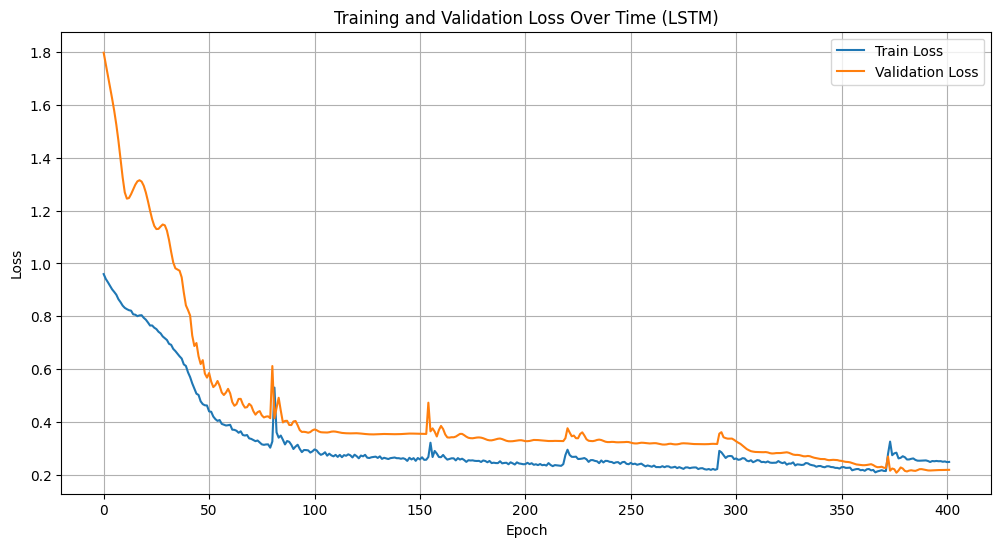

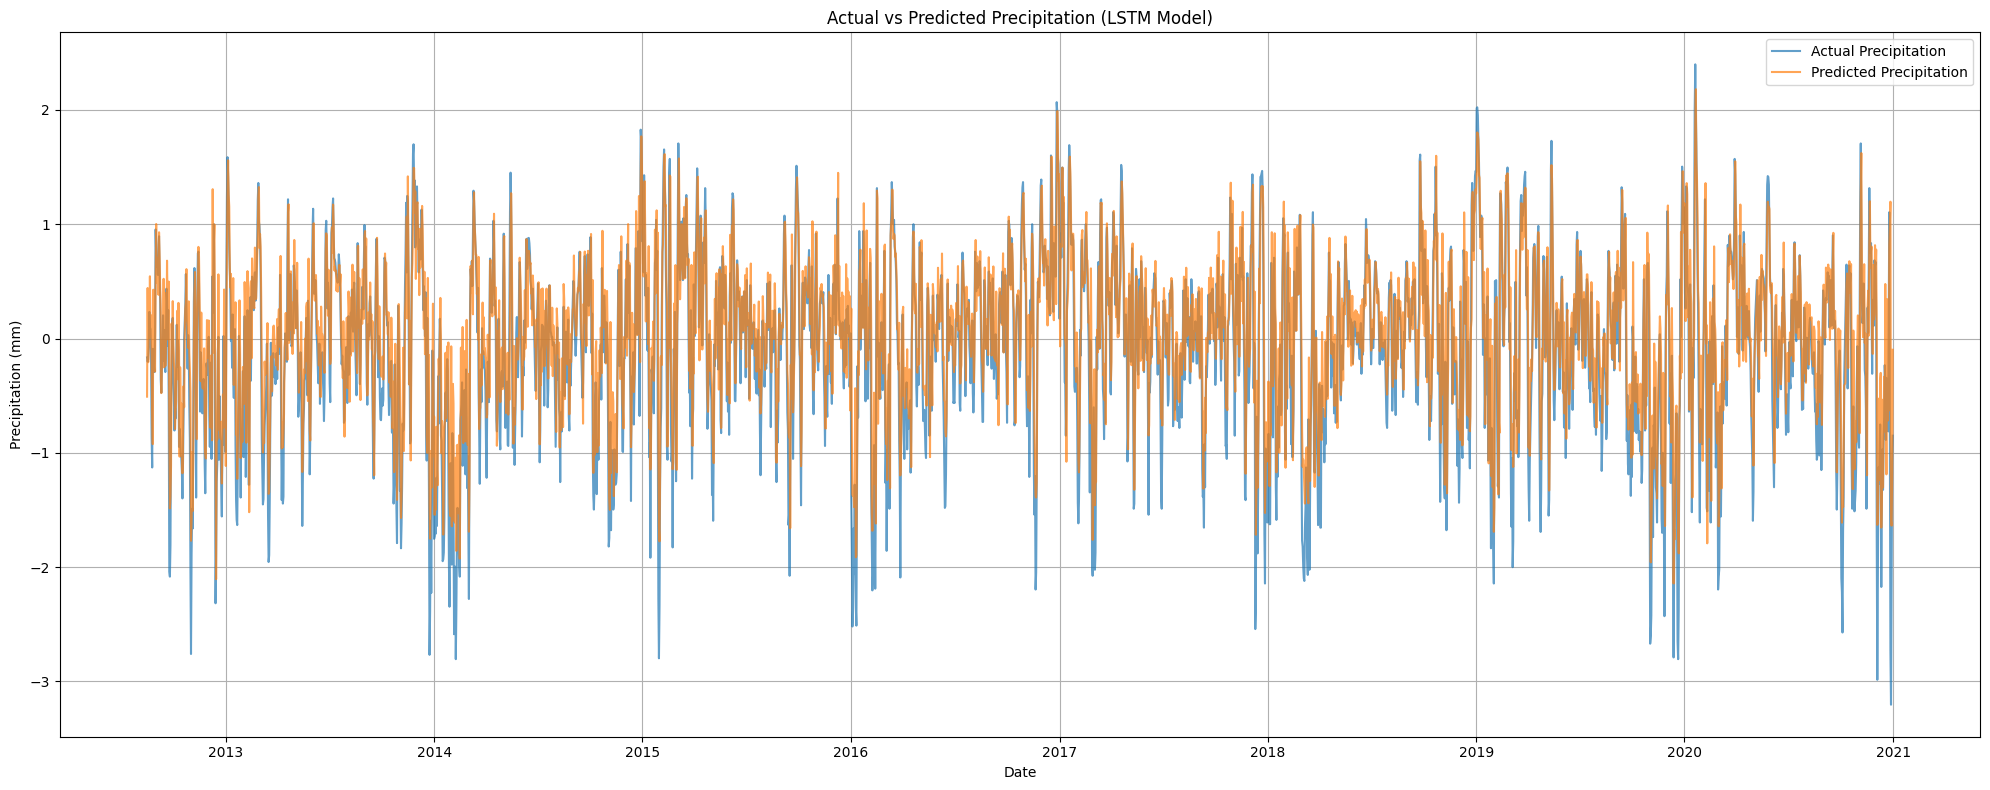

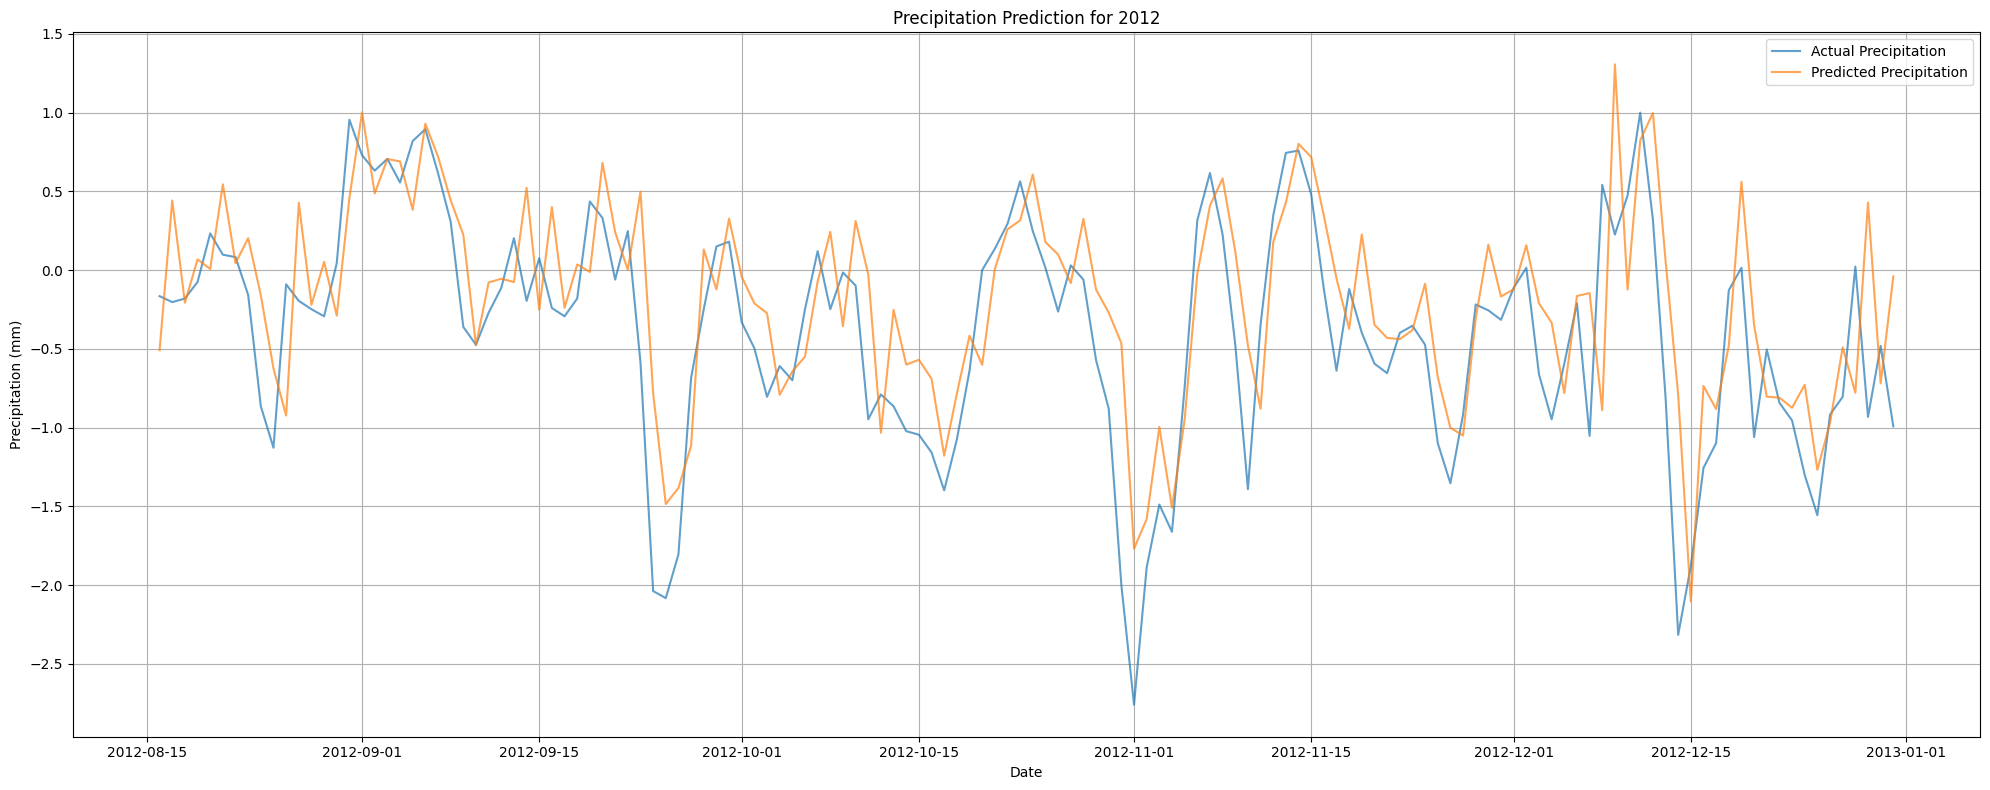

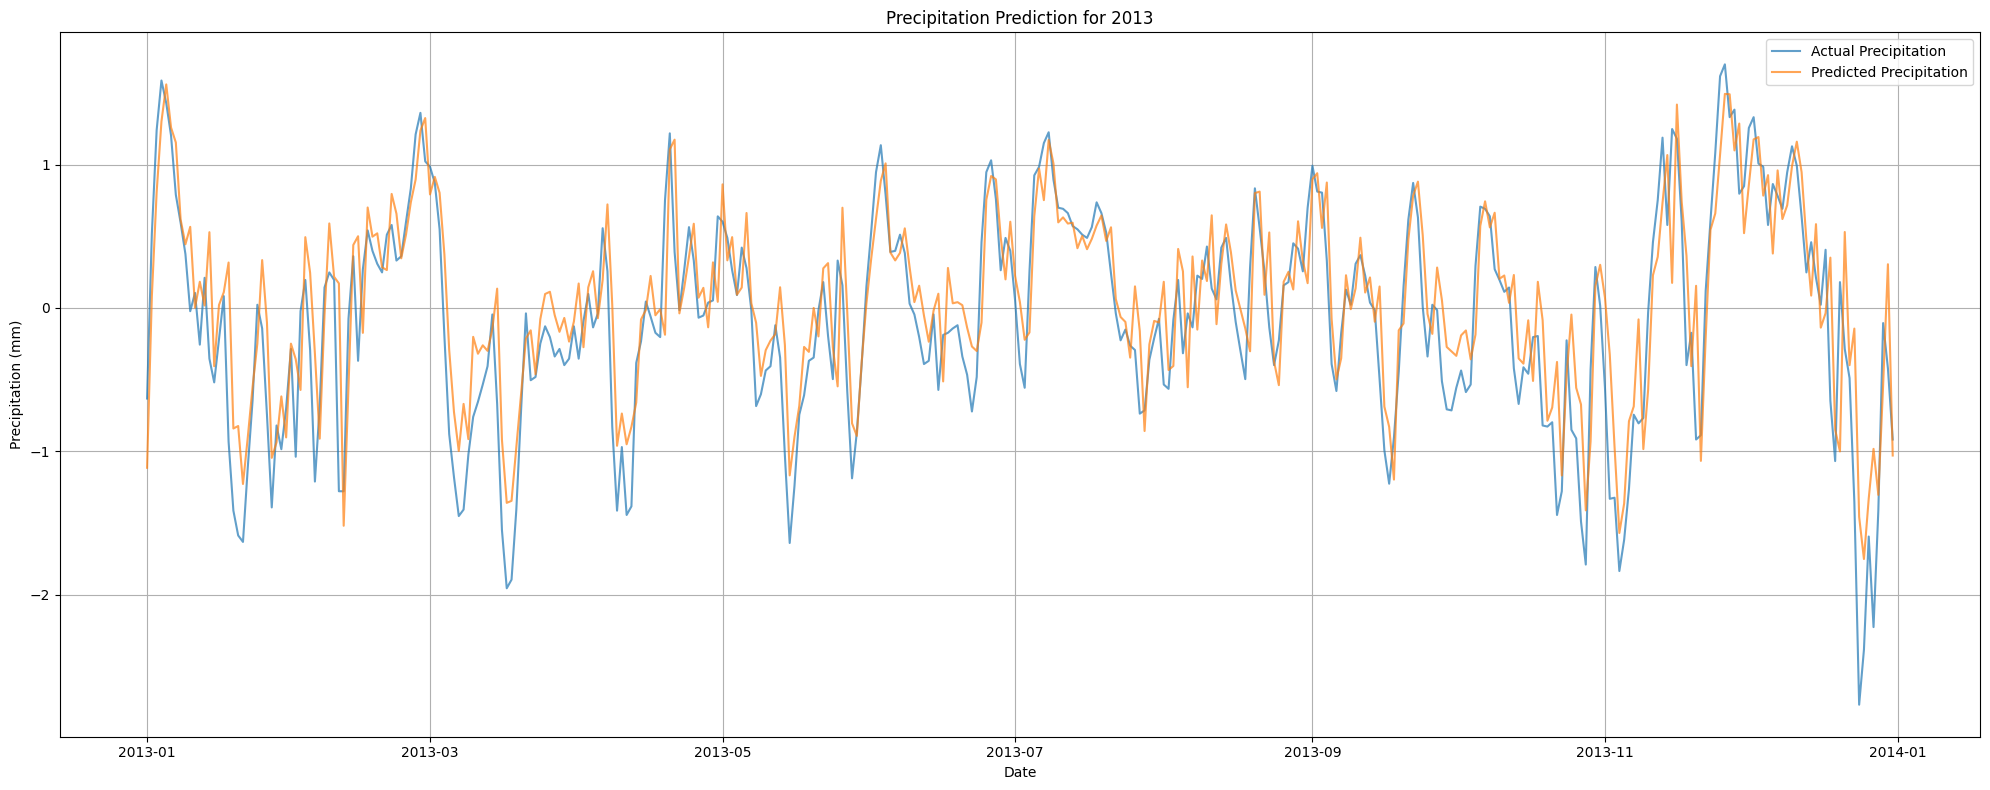

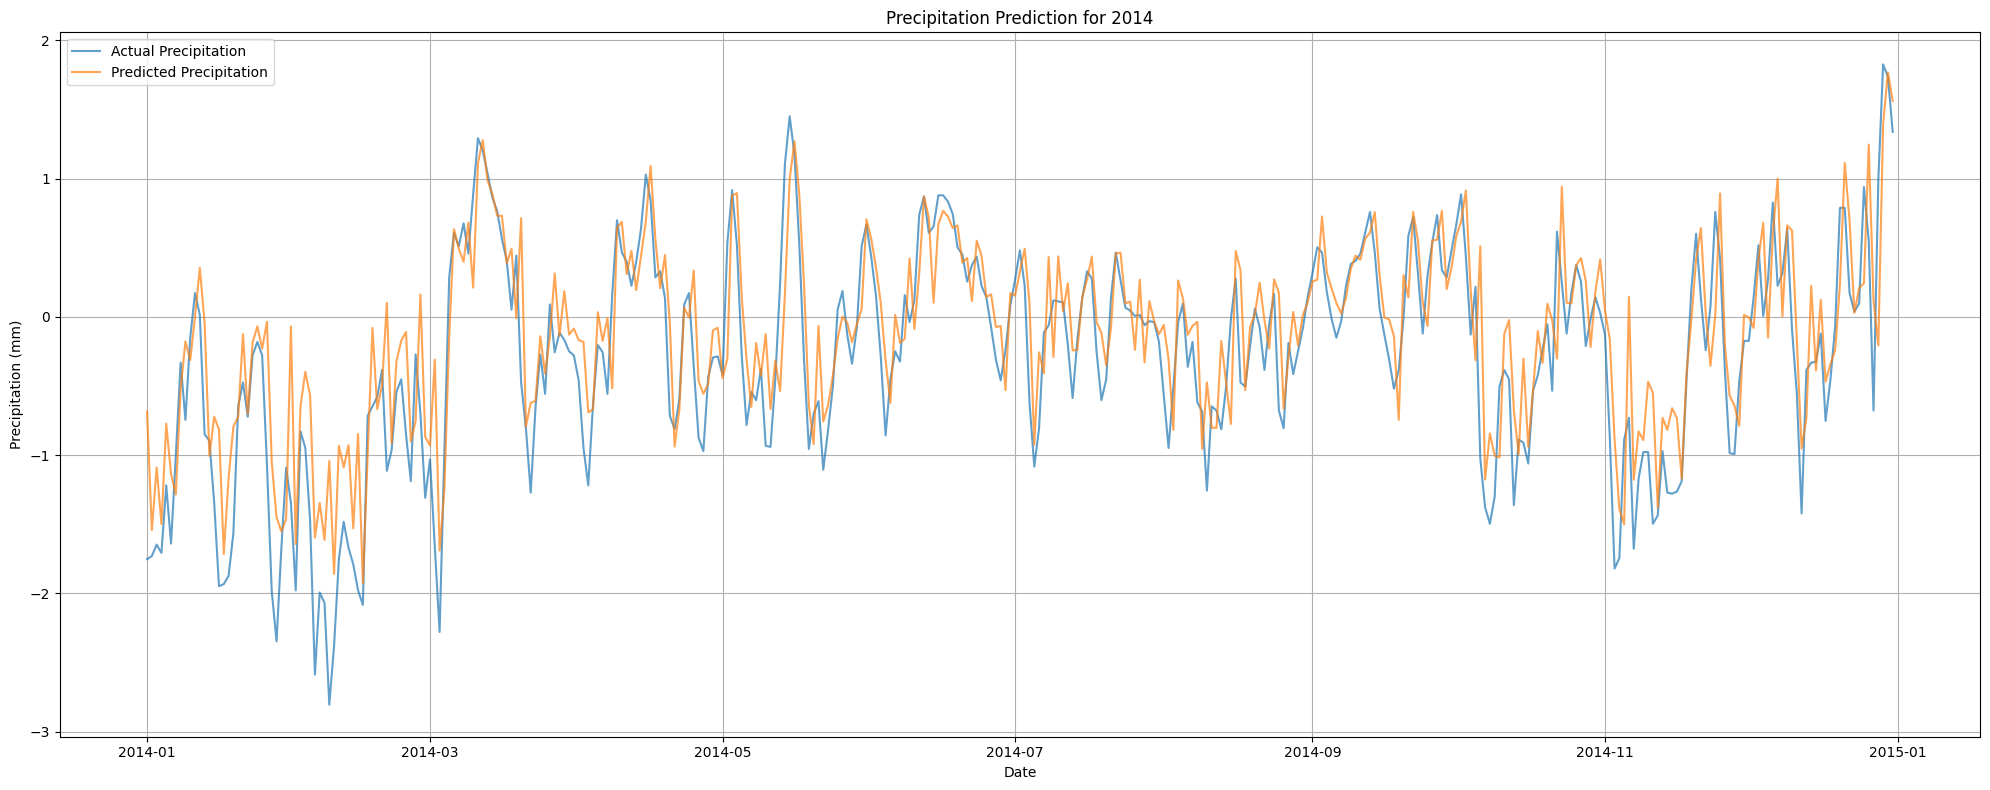

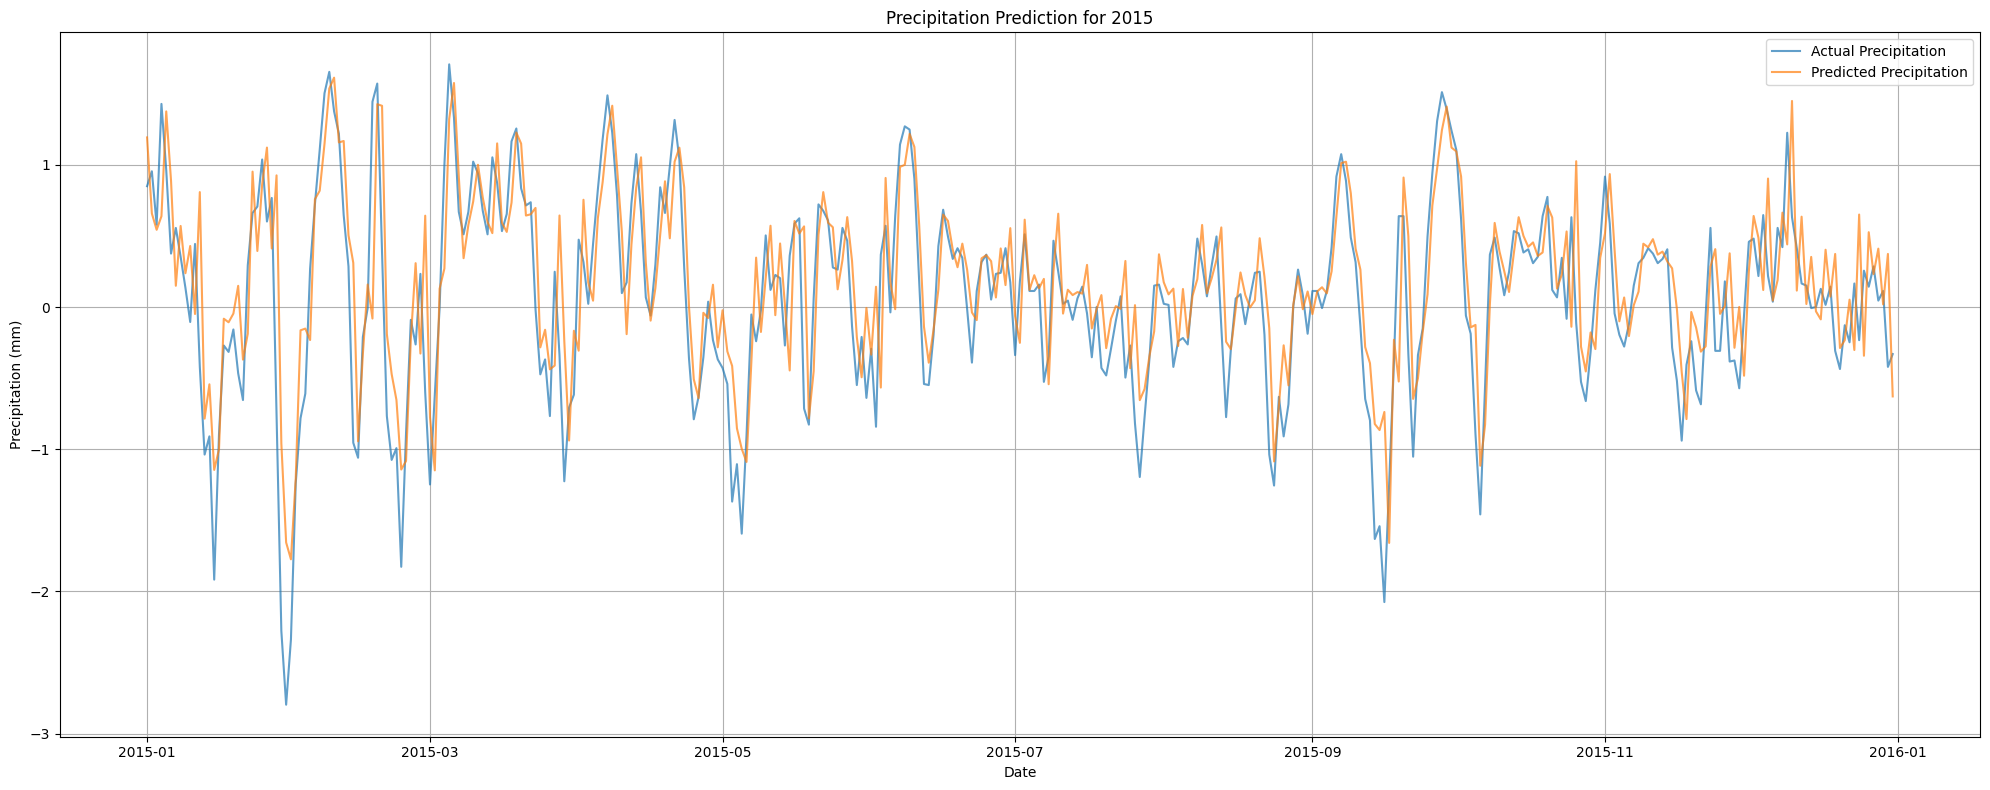

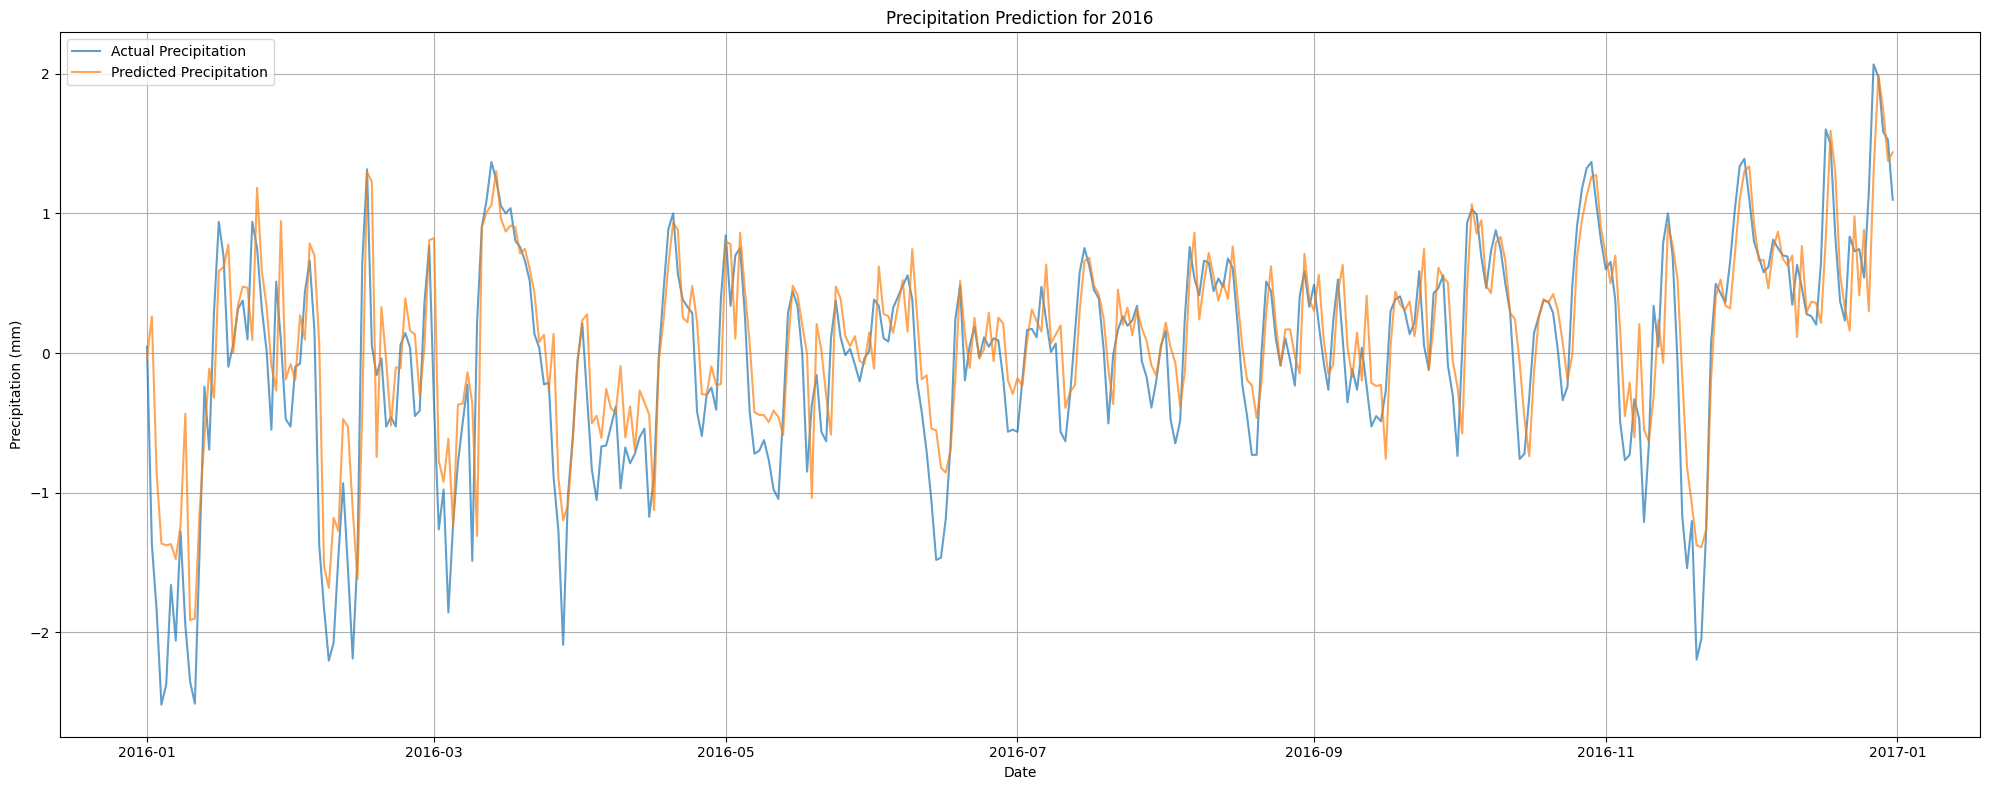

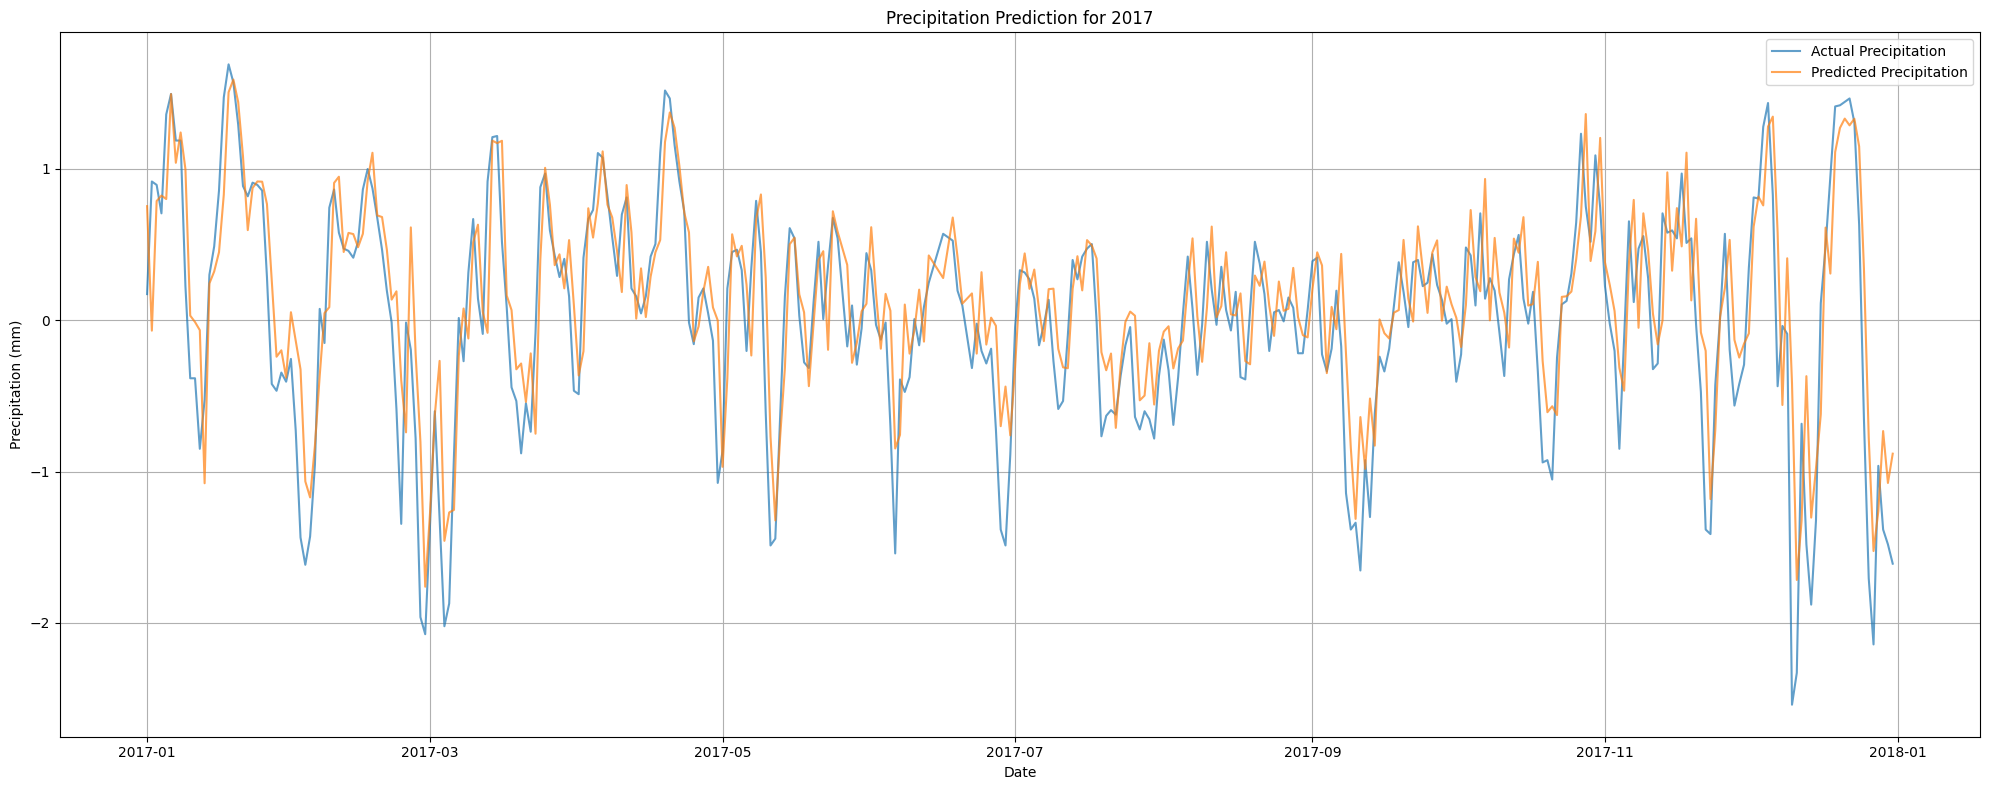

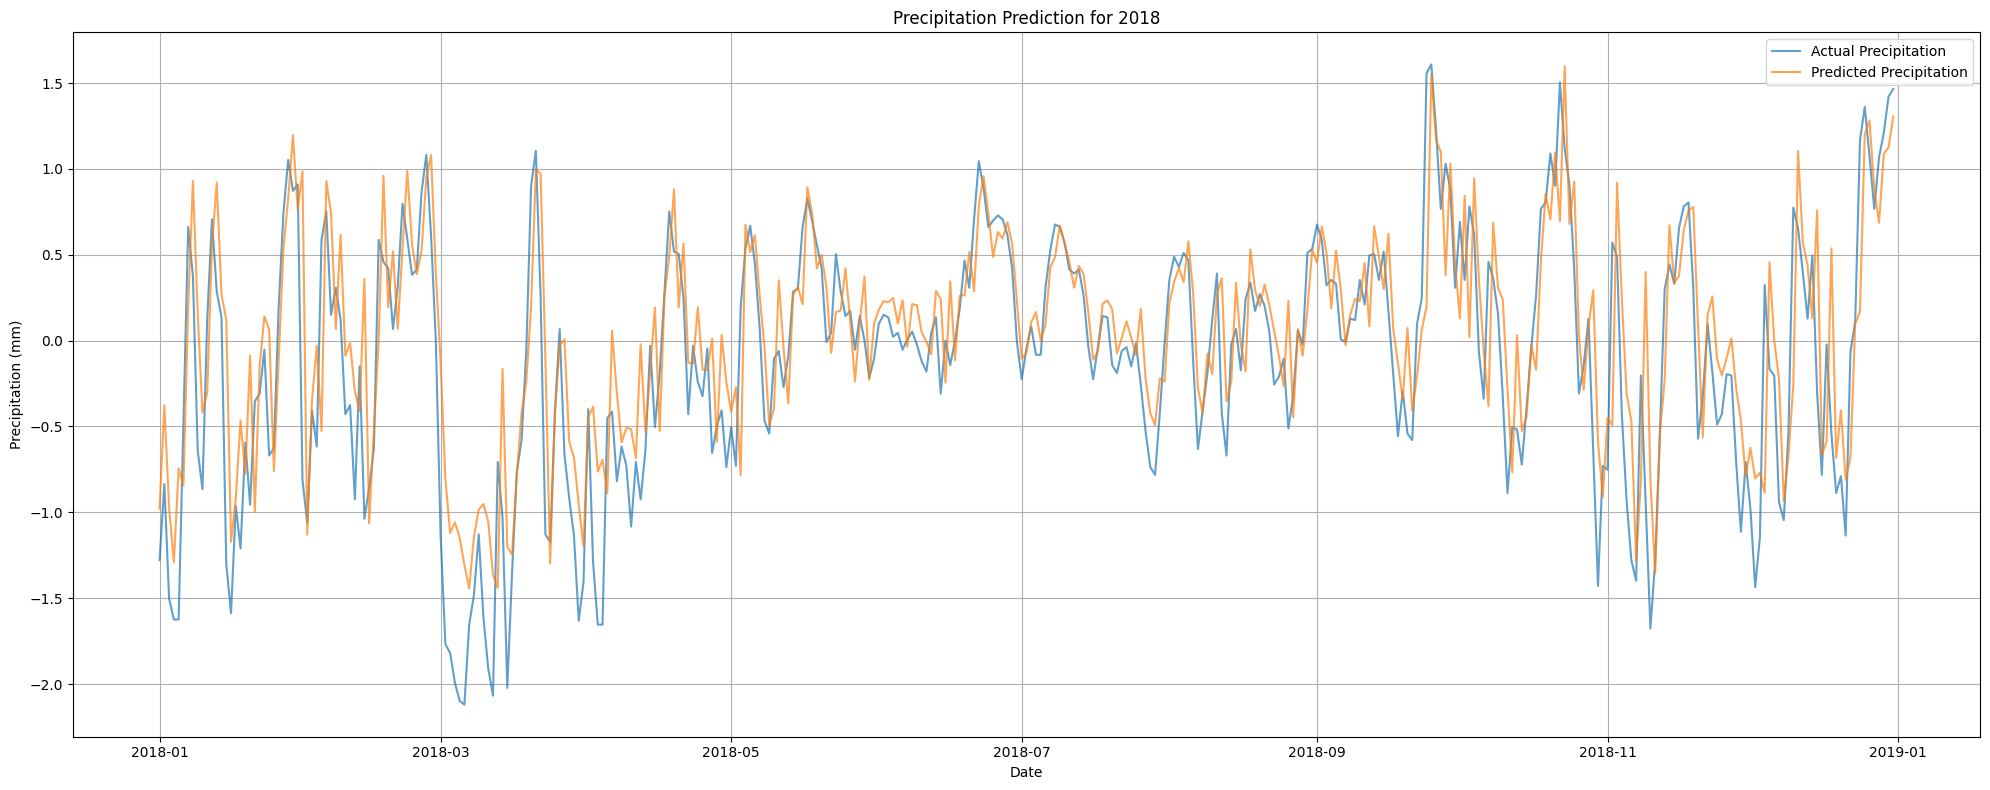

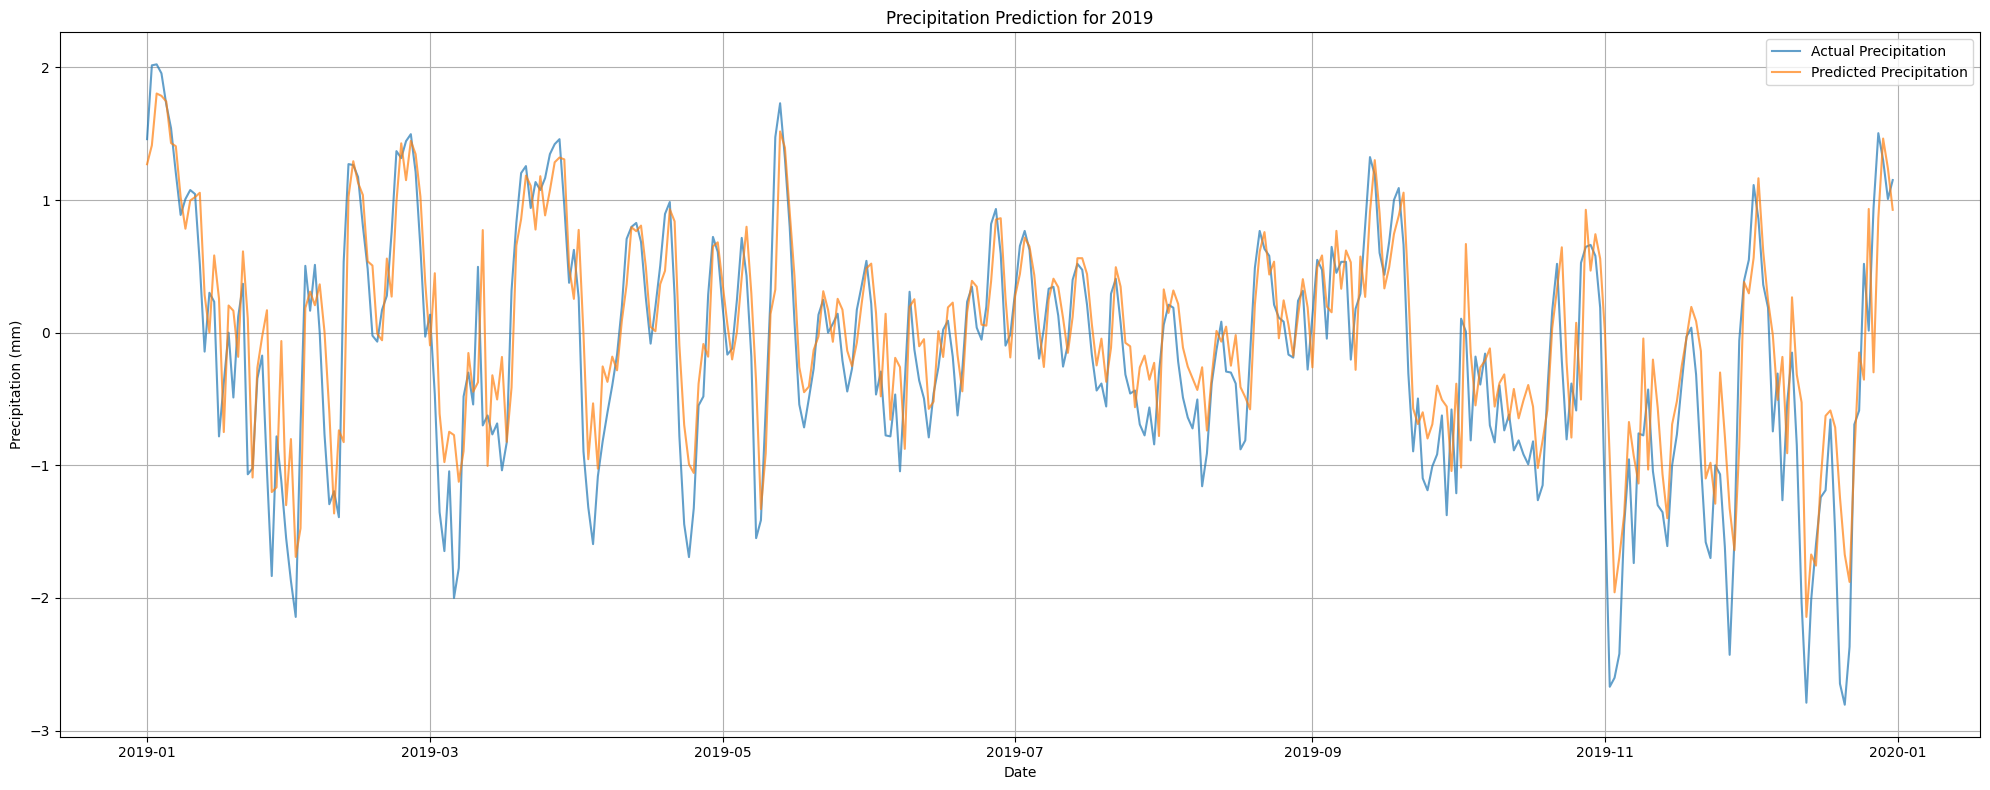

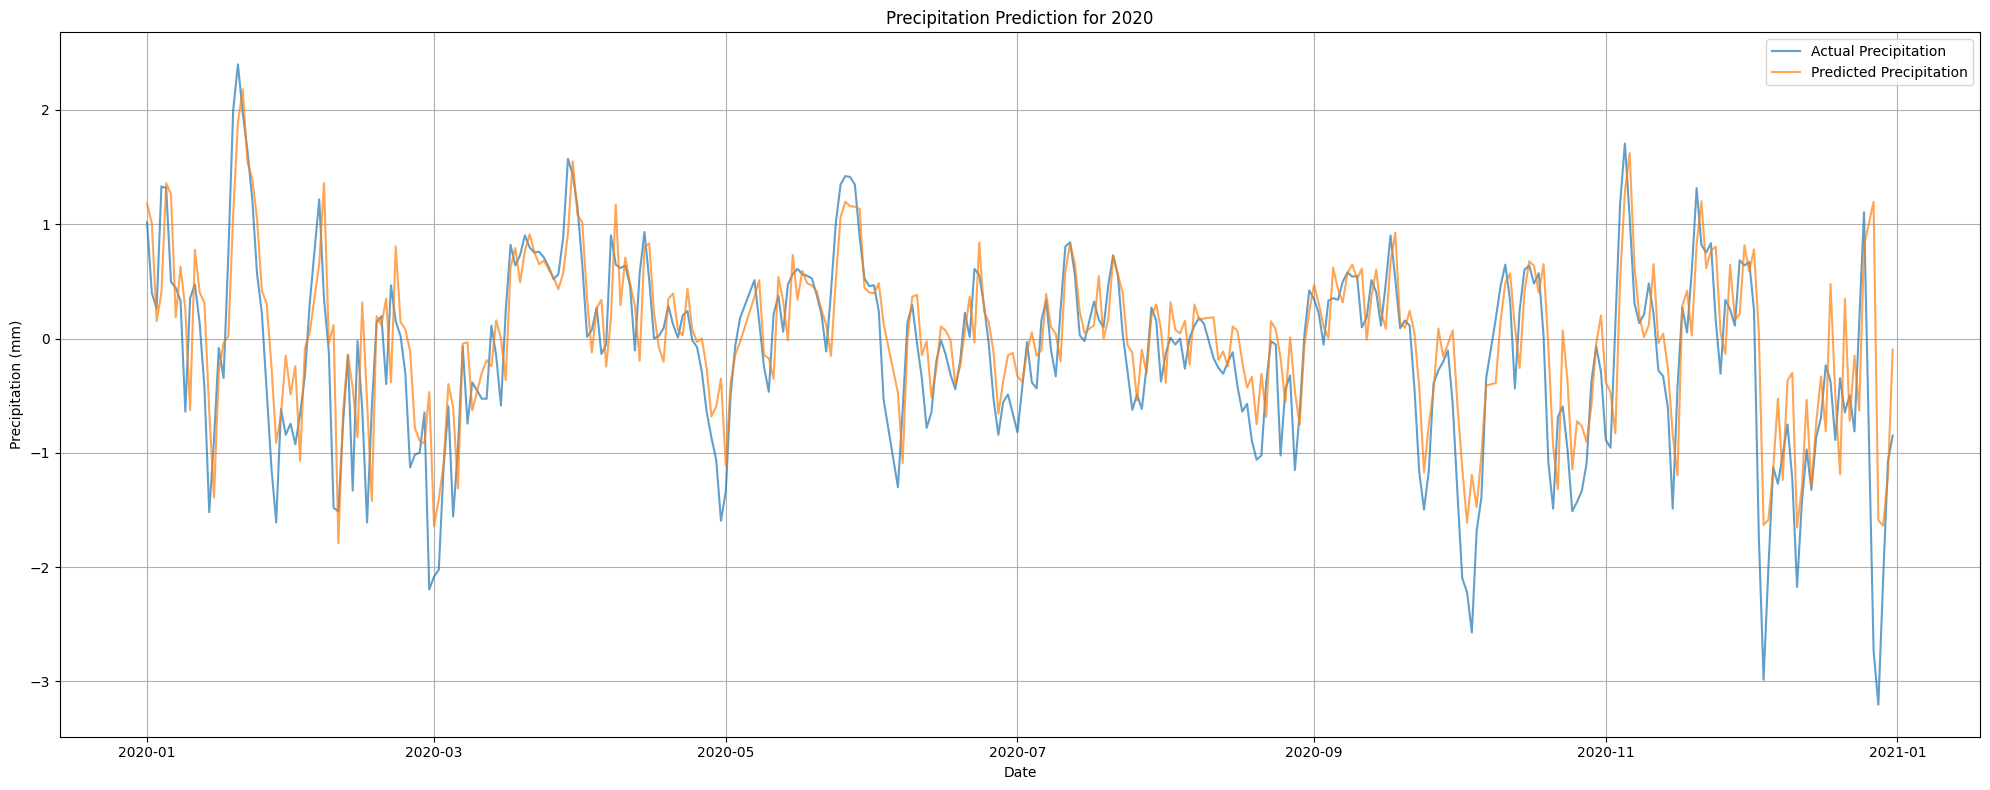

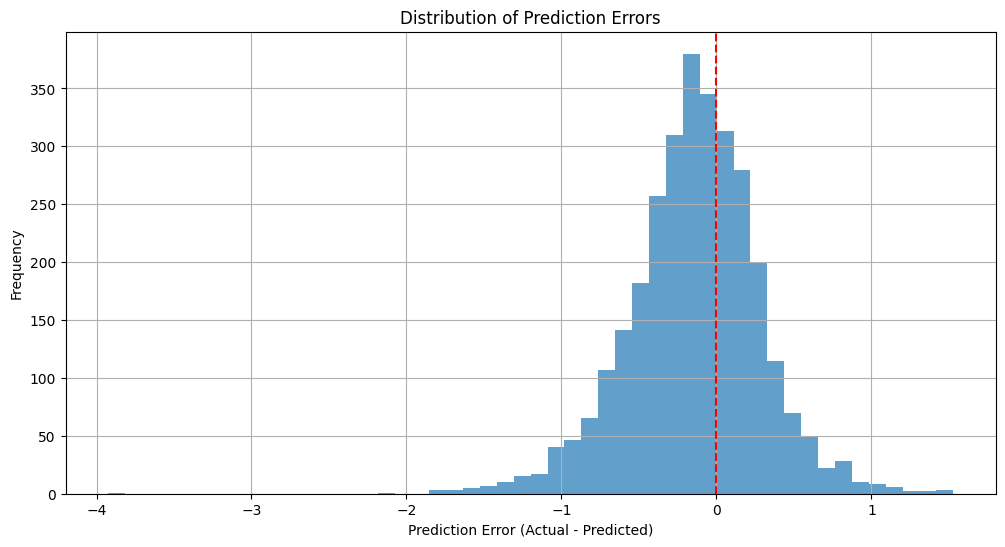

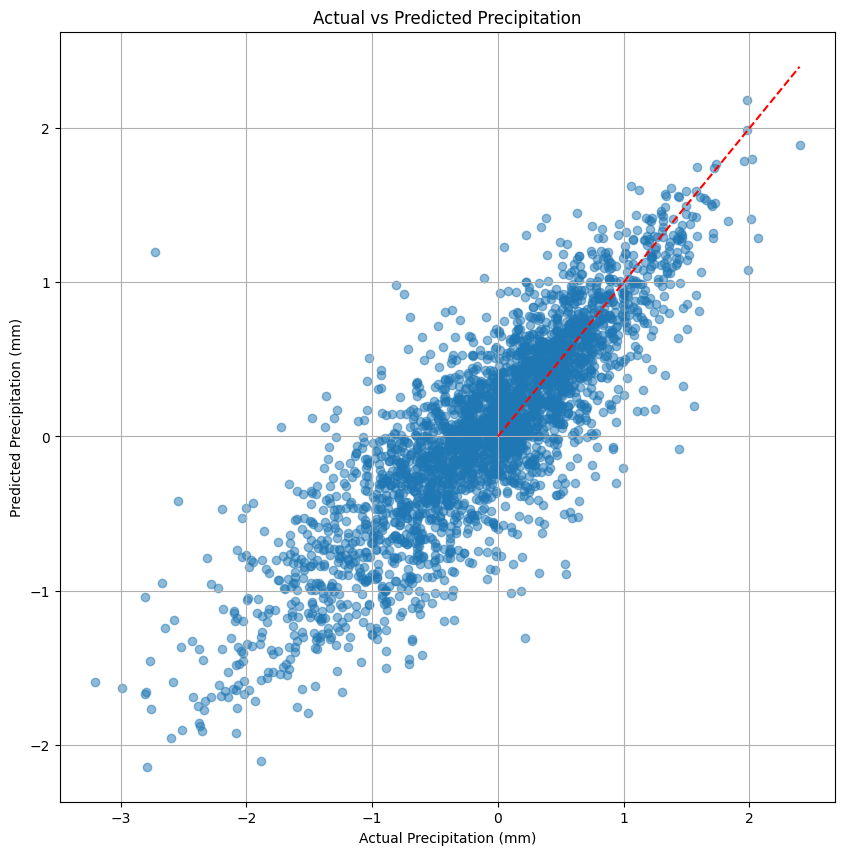

Visualization time: 4.92 seconds

Weather prediction pipeline completed successfully
Total execution time: 75.93 seconds


In [13]:
# Step 5: Display
print("\n=== Display ===")
visualization_start_time = time.time()
displayer = Display(
    show_loss_plot=True,
    show_main_plot=True,
    show_yearly_plot=True,
    show_error_hist=True,
    show_scatter_plot=True
)

results_df = displayer.visualize(
    preprocessor.clean_data,
    all_model_predictions,
    preprocessor.y_test_seq,
    all_train_losses,
    all_val_losses,
    preprocessor.train_size,
    errors
)
visualization_time = time.time() - visualization_start_time
print(f"Visualization time: {visualization_time:.2f} seconds")

# Calculate and print total execution time
total_time = time.time() - main_start_time
print("\nWeather prediction pipeline completed successfully")
print(f"Total execution time: {total_time:.2f} seconds")